In [103]:
!pip -q install pythainlp datasets scikit-learn tqdm matplotlib
import os, json, random, copy
import numpy as np
import pandas as pd

from datasets import DatasetDict, Dataset
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch, torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

ส่วนการดึงdataมาจากgithub

In [104]:
REPO = "https://github.com/jimjumkimji/deeplearnproject"
LOCAL = "deeplearnproject"

if not os.path.exists(LOCAL):
    !git clone --depth=1 "$REPO"
else:
    %cd $LOCAL
    !git pull --ff-only
    %cd ..

/content/deeplearnproject
Already up to date.
/content


ส่วนของการตั้งค่า

In [105]:
from types import SimpleNamespace

ARGS = SimpleNamespace(
    data_dir="/content/deeplearnproject/data",
    out_dir="/content/runs/check_hybrid",
    epochs=20,
    batch_size=32,
    eval_batch_size=None,
    lr=3e-4,
    max_words=128,
    word_emb_dim=300,
    word_channels=256,
    grad_accum=1,
    seed=42,
)
print(ARGS)


namespace(data_dir='/content/deeplearnproject/data', out_dir='/content/runs/check_hybrid', epochs=20, batch_size=32, eval_batch_size=None, lr=0.0003, max_words=128, word_emb_dim=300, word_channels=256, grad_accum=1, seed=42)


In [106]:
print("ARGS.data_dir =", ARGS.data_dir)
need = ["pos.txt","neu.txt","neg.txt","q.txt"]
for fn in need:
    p = os.path.join(ARGS.data_dir, fn)
    exists = os.path.exists(p)
    n_lines = sum(1 for _ in open(p, encoding="utf-8")) if exists else 0
    print(f"{fn:8s} exists={exists}  lines={n_lines}")


ARGS.data_dir = /content/deeplearnproject/data
pos.txt  exists=True  lines=4778
neu.txt  exists=True  lines=14563
neg.txt  exists=True  lines=6823
q.txt    exists=True  lines=575


In [107]:
def load_local_dataset_stratified(root: str) -> DatasetDict:
    paths = {k: os.path.join(root, f"{k}.txt") for k in LABELS}
    for k,p in paths.items():
        if not os.path.exists(p):
            raise FileNotFoundError(f"Missing file: {p}")

    rows = []
    for k,p in paths.items():
        with open(p, encoding="utf-8") as f:
            for line in f:
                t = line.strip()
                if t:
                    rows.append({"text": t, "label": LABMAP[k]})
    if not rows:
        raise RuntimeError("No data found. Check your txt files.")

    df = pd.DataFrame(rows)
    train_df, temp_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df["label"]
    )
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"]
    )
    print("Counts (all) :", df["label"].value_counts().sort_index().to_dict())
    print("Counts (train):", train_df["label"].value_counts().sort_index().to_dict())
    print("Counts (val)  :", val_df["label"].value_counts().sort_index().to_dict())
    print("Counts (test) :", test_df["label"].value_counts().sort_index().to_dict())

    return DatasetDict({
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
    })

set_seed(ARGS.seed)
ds = load_local_dataset_stratified(ARGS.data_dir)


Counts (all) : {0: 4778, 1: 14561, 2: 6823, 3: 575}
Counts (train): {0: 3822, 1: 11649, 2: 5458, 3: 460}
Counts (val)  : {0: 478, 1: 1456, 2: 682, 3: 58}
Counts (test) : {0: 478, 1: 1456, 2: 683, 3: 57}



ส่วนการ ตัดคำด้วย PyThaiNLP→ สร้าง vocab → เข้ารหัส → ทำ collate → สร้าง DataLoader


In [108]:
def word_tokenizer_fn(text: str):
    return thai_word_tokenize(text, engine="newmm")

# สร้างเฉพาะ word vocab
all_texts = []
for split in ["train","validation","test"]:
    all_texts += ds[split]["text"]
word_stoi, _ = build_word_vocab(all_texts, tokenizer=word_tokenizer_fn, min_freq=1, max_size=None)
print("word_vocab_size:", len(word_stoi))

# map → word ids
def enc_map_word(batch):
    return {"word_input_ids": [encode_words(t, word_stoi, ARGS.max_words, word_tokenizer_fn) for t in batch["text"]]}

ds_tok = DatasetDict({k: v.map(enc_map_word, batched=True) for k, v in ds.items()})

# collate เฉพาะคำ
max_word_kernel = max(DEFAULT_WORD_KERNELS)

def collate_batch_word(examples):
    max_word_len = min(ARGS.max_words, max(len(e["word_input_ids"]) for e in examples))
    max_word_len = max(max_word_len, max_word_kernel)
    word_ids, word_attn, labels = [], [], []
    for e in examples:
        w_ids = e["word_input_ids"][:max_word_len]
        pad = [WORD_PAD_ID] * (max_word_len - len(w_ids))
        word_ids.append(w_ids + pad)
        word_attn.append([1]*len(w_ids) + [0]*len(pad))
        labels.append(e["label"])
    return {
        "word_input_ids": torch.tensor(word_ids, dtype=torch.long),
        "word_attention_mask": torch.tensor(word_attn, dtype=torch.long),
        "labels": torch.tensor(labels, dtype=torch.long),
    }

eval_bs = ARGS.eval_batch_size or ARGS.batch_size
train_loader = DataLoader(ds_tok["train"], batch_size=ARGS.batch_size, shuffle=True,  collate_fn=collate_batch_word)
val_loader   = DataLoader(ds_tok["validation"], batch_size=eval_bs, shuffle=False, collate_fn=collate_batch_word)
test_loader  = DataLoader(ds_tok["test"], batch_size=eval_bs, shuffle=False, collate_fn=collate_batch_word)

len(train_loader), len(val_loader), len(test_loader)


word_vocab_size: 33080


Map:   0%|          | 0/21389 [00:00<?, ? examples/s]

Map:   0%|          | 0/2674 [00:00<?, ? examples/s]

Map:   0%|          | 0/2674 [00:00<?, ? examples/s]

(669, 84, 84)

ส่วนโมเดล TextCNN

In [109]:
class WordTextClassifier(nn.Module):
    def __init__(
        self,
        word_vocab_size: int,
        num_labels: int,
        word_embed_dim: int = 300,
        word_channels: int = 256,
        word_kernels=(2, 3, 4, 5),
        word_dropout: float = 0.3,
    ):
        super().__init__()
        self.word_encoder = ConvEncoder(
            vocab_size=word_vocab_size,
            embed_dim=word_embed_dim,
            channels=word_channels,
            kernels=word_kernels,
            dropout=word_dropout,
            padding_idx=WORD_PAD_ID,
        )
        self.fc = nn.Linear(self.word_encoder.out_dim, num_labels)

    def forward(self, word_input_ids=None, labels=None, **kwargs):
        if word_input_ids is None:
            raise ValueError("Expected word_input_ids")
        word_feats = self.word_encoder(word_input_ids)
        logits = self.fc(word_feats)
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return {"loss": loss, "logits": logits}

def evaluate_model_word(model: nn.Module, dataloader: DataLoader, device: torch.device) -> dict:
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss, total_examples = 0.0, 0
    preds, labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = move_batch_to_device(batch, device)
            outputs = model(word_input_ids=batch["word_input_ids"], labels=batch["labels"])
            logits = outputs["logits"]
            loss = criterion(logits, batch["labels"])
            bs = batch["labels"].size(0)
            total_loss += loss.item() * bs
            total_examples += bs
            preds.append(logits.argmax(dim=-1).cpu().numpy())
            labels.append(batch["labels"].cpu().numpy())
    y_pred = np.concatenate(preds) if preds else np.array([])
    y_true = np.concatenate(labels) if labels else np.array([])
    return {
        "loss": total_loss / max(total_examples, 1),
        "accuracy": accuracy_score(y_true, y_pred) if y_true.size else 0.0,
        "f1_macro": f1_score(y_true, y_pred, average="macro") if y_true.size else 0.0,
        "preds": y_pred,
        "labels": y_true,
    }


ขั้นตอนการเทรน สร้าง WordTextClassifier → ส่งขึ้น device → ตั้ง AdamW(lr=ARGS.lr) ลูป epoch วัดผล val


In [110]:
model = WordTextClassifier(
    word_vocab_size=len(word_stoi),
    num_labels=len(LABELS),
    word_embed_dim=ARGS.word_emb_dim,
    word_channels=ARGS.word_channels,
    word_kernels=DEFAULT_WORD_KERNELS,
    word_dropout=0.2,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=ARGS.lr)

best_state = copy.deepcopy(model.state_dict())
best_metric = -float("inf")

for epoch in range(ARGS.epochs):
    model.train()
    optimizer.zero_grad()
    total_loss, total_examples = 0.0, 0
    pbar = tqdm(enumerate(train_loader, 1), total=len(train_loader),
                desc=f"Epoch {epoch+1}/{ARGS.epochs}", leave=False)

    for step, batch in pbar:
        batch = move_batch_to_device(batch, device)
        out = model(word_input_ids=batch["word_input_ids"], labels=batch["labels"])
        loss = out["loss"]
        bs = batch["labels"].size(0)
        total_loss += loss.item() * bs
        total_examples += bs

        (loss / ARGS.grad_accum).backward()
        if step % ARGS.grad_accum == 0 or step == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()

    train_loss = total_loss / max(total_examples, 1)
    val_metrics = evaluate_model_word(model, val_loader, device)

    if val_metrics["f1_macro"] > best_metric:
        best_metric = val_metrics["f1_macro"]
        best_state = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch+1}: train_loss={train_loss:.4f} "
          f"val_loss={val_metrics['loss']:.4f} "
          f"val_acc={val_metrics['accuracy']:.4f} "
          f"val_f1={val_metrics['f1_macro']:.4f}")

print("Best val F1:", best_metric)


Epoch 1/20:   0%|          | 0/669 [00:00<?, ?it/s]

Epoch 1: train_loss=0.8936 val_loss=0.7960 val_acc=0.6761 val_f1=0.4695


Epoch 2/20:   0%|          | 0/669 [00:00<?, ?it/s]

Epoch 2: train_loss=0.6130 val_loss=0.7640 val_acc=0.6836 val_f1=0.5332


Epoch 3/20:   0%|          | 0/669 [00:00<?, ?it/s]

Epoch 3: train_loss=0.4252 val_loss=0.7984 val_acc=0.6960 val_f1=0.5284


Epoch 4/20:   0%|          | 0/669 [00:00<?, ?it/s]

Epoch 4: train_loss=0.2857 val_loss=0.8155 val_acc=0.6967 val_f1=0.5395


Epoch 5/20:   0%|          | 0/669 [00:00<?, ?it/s]

Epoch 5: train_loss=0.1976 val_loss=0.8325 val_acc=0.7004 val_f1=0.5687


Epoch 6/20:   0%|          | 0/669 [00:00<?, ?it/s]

Epoch 6: train_loss=0.1466 val_loss=0.8952 val_acc=0.6941 val_f1=0.5545


Epoch 7/20:   0%|          | 0/669 [00:00<?, ?it/s]

Epoch 7: train_loss=0.1181 val_loss=0.9662 val_acc=0.7094 val_f1=0.5360


Epoch 8/20:   0%|          | 0/669 [00:00<?, ?it/s]

Epoch 8: train_loss=0.1066 val_loss=0.9890 val_acc=0.7061 val_f1=0.5623


Epoch 9/20:   0%|          | 0/669 [00:00<?, ?it/s]

Epoch 9: train_loss=0.0855 val_loss=1.0418 val_acc=0.6900 val_f1=0.5548


Epoch 10/20:   0%|          | 0/669 [00:00<?, ?it/s]

Epoch 10: train_loss=0.0793 val_loss=1.1490 val_acc=0.6937 val_f1=0.5558


Epoch 11/20:   0%|          | 0/669 [00:00<?, ?it/s]

Epoch 11: train_loss=0.0772 val_loss=1.1395 val_acc=0.7004 val_f1=0.5509


Epoch 12/20:   0%|          | 0/669 [00:00<?, ?it/s]

Epoch 12: train_loss=0.0773 val_loss=1.1670 val_acc=0.6941 val_f1=0.5644


Epoch 13/20:   0%|          | 0/669 [00:00<?, ?it/s]

Epoch 13: train_loss=0.0596 val_loss=1.3231 val_acc=0.6948 val_f1=0.5277


Epoch 14/20:   0%|          | 0/669 [00:00<?, ?it/s]

Epoch 14: train_loss=0.0611 val_loss=1.2903 val_acc=0.6933 val_f1=0.5555


Epoch 15/20:   0%|          | 0/669 [00:00<?, ?it/s]

Epoch 15: train_loss=0.0650 val_loss=1.3272 val_acc=0.6952 val_f1=0.5449


Epoch 16/20:   0%|          | 0/669 [00:00<?, ?it/s]

Epoch 16: train_loss=0.0558 val_loss=1.3785 val_acc=0.7016 val_f1=0.5604


Epoch 17/20:   0%|          | 0/669 [00:00<?, ?it/s]

Epoch 17: train_loss=0.0549 val_loss=1.4252 val_acc=0.7019 val_f1=0.5489


Epoch 18/20:   0%|          | 0/669 [00:00<?, ?it/s]

Epoch 18: train_loss=0.0529 val_loss=1.3668 val_acc=0.6832 val_f1=0.5457


Epoch 19/20:   0%|          | 0/669 [00:00<?, ?it/s]

Epoch 19: train_loss=0.0443 val_loss=1.4460 val_acc=0.7008 val_f1=0.5590


Epoch 20/20:   0%|          | 0/669 [00:00<?, ?it/s]

Epoch 20: train_loss=0.0465 val_loss=1.5044 val_acc=0.7023 val_f1=0.5547
Best val F1: 0.5686866300289848


TEST acc : 0.7061
TEST f1  : 0.5425

Confusion Matrix (counts):
          pred_pos  pred_neu  pred_neg  pred_q
true_pos       201       238        36       3
true_neu       118      1221       107      10
true_neg        39       185       458       1
true_q           2        42         5       8

Saved to : /content/runs/check_hybrid


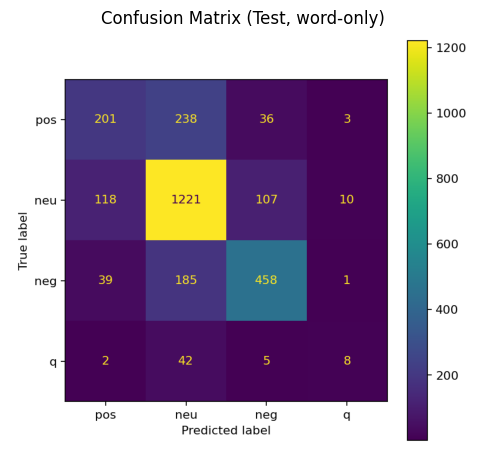


Confusion Matrix (%) by true class:
          pred_pos  pred_neu  pred_neg  pred_q
true_pos      42.1      49.8       7.5     0.6
true_neu       8.1      83.9       7.3     0.7
true_neg       5.7      27.1      67.1     0.1
true_q         3.5      73.7       8.8    14.0


In [111]:
# ใช้ best weights
model.load_state_dict(best_state)

# ประเมินบน test
test_metrics = evaluate_model_word(model, test_loader, device)
y_true = test_metrics["labels"]
y_pred = test_metrics["preds"]

labels_idx = list(range(len(LABELS)))  # [0,1,2,3]
report = {
    "test_accuracy": float(test_metrics["accuracy"]),
    "test_f1_macro": float(test_metrics["f1_macro"]),
    "classification_report": classification_report(
        y_true, y_pred,
        labels=labels_idx,
        target_names=LABELS,
        output_dict=True,
        zero_division=0,
    ),
    "args": vars(ARGS),
}

os.makedirs(ARGS.out_dir, exist_ok=True)
with open(os.path.join(ARGS.out_dir, "eval_report.json"), "w", encoding="utf-8") as f:
    json.dump(report, f, ensure_ascii=False, indent=2)
torch.save(model.state_dict(), os.path.join(ARGS.out_dir, "pytorch_model_wordonly.bin"))

# พิมพ์และเซฟ Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=labels_idx)
cm_df = pd.DataFrame(cm, index=[f"true_{l}" for l in LABELS], columns=[f"pred_{l}" for l in LABELS])
print("TEST acc : %.4f" % test_metrics["accuracy"])
print("TEST f1  : %.4f" % test_metrics["f1_macro"])
print("\nConfusion Matrix (counts):")
print(cm_df.to_string())

# รูป CM
def save_cm_png(cm_arr, out_png):
    from sklearn.metrics import ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(cm_arr, display_labels=LABELS)
    fig = disp.plot(values_format="d").figure_
    fig.set_figwidth(6); fig.set_figheight(6)
    fig.savefig(out_png, dpi=160, bbox_inches="tight"); plt.close(fig)

cm_png = os.path.join(ARGS.out_dir, "cm_test_wordonly.png")
save_cm_png(cm, cm_png)
print("\nSaved to :", ARGS.out_dir)

if os.path.exists(cm_png):
    img = mpimg.imread(cm_png)
    plt.figure(figsize=(6,6))
    plt.imshow(img); plt.axis('off'); plt.title("Confusion Matrix (Test, word-only)")
    plt.show()

# (ทางเลือก) แสดงเป็นเปอร์เซ็นต์ต่อคลาสจริง
cm_pct = (cm / cm.sum(axis=1, keepdims=True).clip(min=1)) * 100
print("\nConfusion Matrix (%) by true class:")
print(pd.DataFrame(np.round(cm_pct,1),
                   index=[f"true_{l}" for l in LABELS],
                   columns=[f"pred_{l}" for l in LABELS]).to_string())
